In [22]:
# 데이터 전처리, 데이터 증강
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

In [23]:
# 데이터셋 불러오기
training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = ToTensor()
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = ToTensor()
) 

Files already downloaded and verified
Files already downloaded and verified


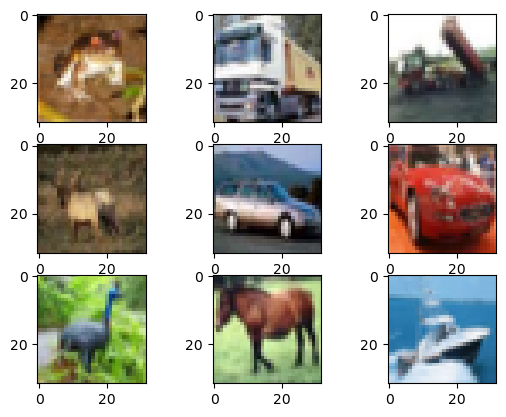

In [24]:
for i in range(9):
    img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0)) # (C,H,W): 0 1 2  -- 1 2 0   (H,W,C)
plt.show()

Files already downloaded and verified
Files already downloaded and verified


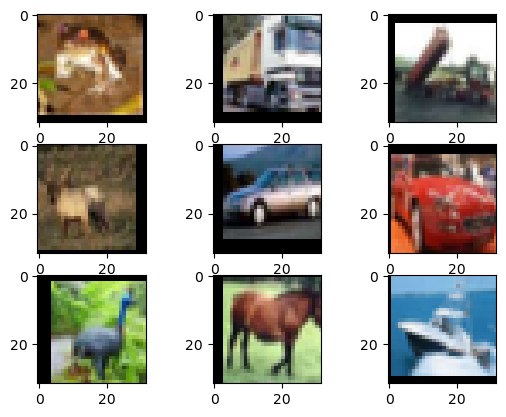

In [25]:
# 크롤링과 뒤집기 추가
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transform = Compose([
    T.ToTensor(),
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(p=0.5)
])
training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = transform
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform
) 
for i in range(9):
    img, label = training_dataset[i]
    plt.subplot(3,3,i+1)
    plt.imshow(img.permute(1,2,0)) # (C,H,W): 0 1 2  -- 1 2 0   (H,W,C)
plt.show()

Files already downloaded and verified
Files already downloaded and verified


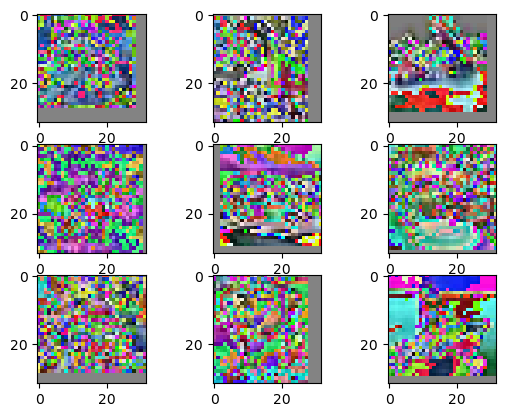

In [26]:
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
# 데이터 전처리에 정규화를 추가
transform = Compose([
    T.ToPILImage(),
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize((0.5,0.5,0.5), (0.2,0.2,0.2)),
    T.ToPILImage(),
])
training_dataset = CIFAR10(
    root = './',
    train = True,
    download = True,
    transform = transform
)
test_dataset = CIFAR10(
    root = './',
    train = False,
    download = True,
    transform = transform
) 
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(transform(training_dataset.data[i]))
plt.show()

In [27]:
from torch import nn
class BasicBlock(nn.Module):
    def __init__(self, int_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(int_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
    def forward(self, x):
        x = self.relu( self.conv1(x) )
        x = self.relu( self.conv2(x) )
        out = self.pool(x)
        return out

In [28]:
import torch

class CNN(nn.Module):
    def __init__(self, num_class):
        super(CNN, self).__init__()
        self.block1 = BasicBlock(3, 64, 64)
        self.block2 = BasicBlock(64, 128, 128)

        # 분류기
        self.fc1 = nn.Linear(128*8*8, 2048)
        self.fc2 = nn.Linear(2048, 256)
        self.fc3 = nn.Linear(256, num_class)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        # (-1, 128*8*8)
        x = torch.flatten(x, start_dim=1)
        x = self.relu( self.fc1(x) )
        x = self.relu( self.fc2(x) )
        out = self.relu( self.fc3(x) )
        return out

In [29]:
# 샘플데이터 생성해서 구조 확인
X = torch.randn(4, 3, 32, 32)
model = CNN(10)
model(X)

tensor([[0.0000, 0.0275, 0.0000, 0.0000, 0.0049, 0.0000, 0.0422, 0.0520, 0.0584,
         0.0000],
        [0.0000, 0.0275, 0.0000, 0.0000, 0.0042, 0.0000, 0.0412, 0.0520, 0.0581,
         0.0000],
        [0.0000, 0.0268, 0.0000, 0.0000, 0.0040, 0.0000, 0.0430, 0.0525, 0.0599,
         0.0000],
        [0.0000, 0.0263, 0.0000, 0.0000, 0.0052, 0.0000, 0.0451, 0.0566, 0.0576,
         0.0000]], grad_fn=<ReluBackward0>)

In [30]:
# %pip install torchsummary

In [31]:
from torchsummary import summary
model = CNN(10)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
        BasicBlock-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
       BasicBlock-12            [-1, 128, 8, 8]               0
           Linear-13                 [-1, 2048]      16,779,264
             ReLU-14                 [-

In [32]:
for name, param in model.named_parameters():
    print(f'{name} {list(param.shape)}')

block1.conv1.weight [64, 3, 3, 3]
block1.conv1.bias [64]
block1.conv2.weight [64, 64, 3, 3]
block1.conv2.bias [64]
block2.conv1.weight [128, 64, 3, 3]
block2.conv1.bias [128]
block2.conv2.weight [128, 128, 3, 3]
block2.conv2.bias [128]
fc1.weight [2048, 8192]
fc1.bias [2048]
fc2.weight [256, 2048]
fc2.bias [256]
fc3.weight [10, 256]
fc3.bias [10]


In [33]:
# 레이어 접근 가능하고 변경도 가능
# model.fc3 = nn.Linear(in_features=256, out_feafures=2, bias=True)

In [ ]:
from torch.optim import Adam
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
# 데이터 증강
transform = Compose([
    RandomCrop((32,32), padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize((0.5,0.5,0.5), (0.2,0.2,0.2)),
])
# 데이터 셋
training_dataset = CIFAR10(root = './',train = True,download = True,transform = transform)
test_dataset = CIFAR10(root = './',train = False,download = True,transform = transform) 
# 데이터 로더
train_loader = DataLoader(training_dataset,batch_size=256,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=256,shuffle=False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(10)
model.to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
epochs = 1
# 학습루프
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'epoch : {epoch+1}'):
        optim.zero_grad()
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()
    if (epoch+1) % 10 == 0:
        print(f'epoch : {epoch+1}, loss : {loss.item()}')

torch.save(model.state_dict(), 'cifar.pth')

In [38]:
# 평가
model.load_state_dict(torch.load('cifar.pth', map_location=device, weights_only=True))
# 예측
num_corr = 0
with torch.no_grad():
    for data, label in tqdm(test_loader):
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
    print(f'Accuracy: {num_corr / len(test_loader)}')

100%|██████████| 40/40 [00:18<00:00,  2.14it/s]

Accuracy: 111.525
